In [1]:
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import numpy as np
import pandas as pd
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50

Using TensorFlow backend.


In [2]:
img_height = 256
img_width = 256
channels = 3
batch_size = 16
epochs = 20

In [3]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1. / 255)
val_set = train_datagen.flow_from_directory(
    './test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical', 
    shuffle=True)


Found 40 images belonging to 4 classes.


In [7]:
num_class = train_set.num_classes
labels = train_set.class_indices.keys()
print(labels)

dict_keys(['COVID-19', 'NORMAL', 'PNEUMONIA', 'TBC'])


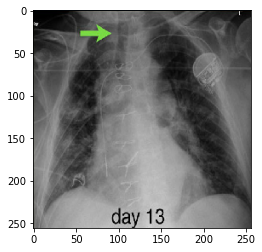

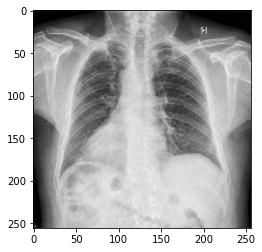

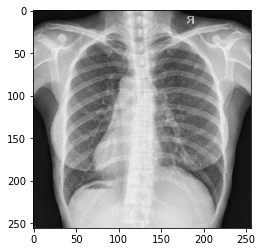

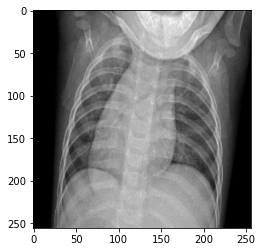

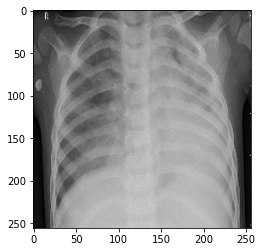

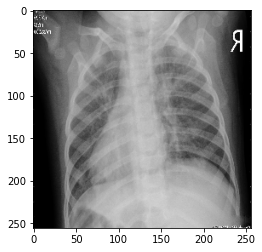

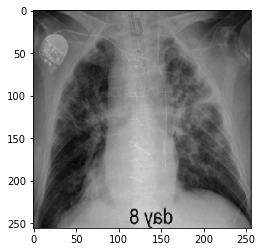

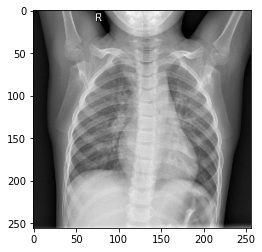

In [8]:
x,y = val_set.next()
for i in range(8):
    image = x[i]
    plt.imshow(image)
    plt.show()

In [9]:
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.models import Model
model = ResNet50(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, channels))

for layer in model.layers:
    layer.trainable = False

headModel = model.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.4)(headModel)
headModel = Dense(num_class, activation="softmax")(headModel)
model = Model(inputs=model.input, outputs=headModel)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [34]:
from keras.utils.vis_utils import plot_model
model_viz = tf.keras.utils.plot_model(model,
                          to_file='modelvgg19.png',
                          show_shapes=False,
                          show_layer_names=True,
                          rankdir='TB',
                          expand_nested=True,
                          dpi=100)
model_viz

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [10]:
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
%matplotlib inline
import math 
import datetime
import time

In [ ]:
start = datetime.datetime.now()
history_tl = model.fit_generator(train_set,
                                 steps_per_epoch=train_set.n // 16,
                                 epochs=5,
                                 validation_data=val_set,
                                 validation_steps=val_set.n // 16)
end= datetime.datetime.now()
elapsed= end-start
print ('Waktu: ', elapsed)
plt.plot(history_tl.history['loss'], label='train loss')
plt.plot(history_tl.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('loss_vgg195')
# plot the accuracy
plt.plot(history_tl.history['accuracy'], label='train acc')
plt.plot(history_tl.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('acc_vgg195')
model.save('TEST.h5')
test_score = model.evaluate_generator(train_set, batch_size)
print('Akurasi',test_score[1]) 
print('Loss',test_score[0])
x = model.evaluate_generator(val_set, batch_size)
print('Akurasi',x[1]) 
print('Loss',x[0])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2 steps, validate for 1 steps
Epoch 1/5
2/2 [==============================] - 172s 86s/step - loss: 2.7930 - accuracy: 0.1562 - val_loss: 1.5451 - val_accuracy: 0.2500
Epoch 2/5
1/2 [==============>...............] - ETA: 1:28 - loss: 0.9049 - accuracy: 0.6250

In [29]:
test_score = model.evaluate_generator(val_set, batch_size)
print('Akurasi',test_score[1]) 
print('Loss',test_score[0])

  ...
    to  
  ['...']
Akurasi 0.94921875
Loss 0.16042706003645435


In [48]:
from sklearn.metrics import classification_report, confusion_matrix
model = tf.keras.models.load_model('RESNETepoch20-80%.h5')
Y_pred = model.predict(val_set)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(val_set.classes, y_pred))
print('Classification Report')
print(classification_report(val_set.classes, y_pred, target_names=labels))

Confusion Matrix
[[45 54 56 45]
 [52 46 54 48]
 [49 51 47 53]
 [50 50 45 55]]
Classification Report
              precision    recall  f1-score   support

    COVID-19       0.23      0.23      0.23       200
      NORMAL       0.23      0.23      0.23       200
   PNEUMONIA       0.23      0.23      0.23       200
         TBC       0.27      0.28      0.27       200

    accuracy                           0.24       800
   macro avg       0.24      0.24      0.24       800
weighted avg       0.24      0.24      0.24       800



In [13]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Found 40 images belonging to 4 classes.
Confusion Matrix
Confusion matrix, without normalization
Classification Report
              precision    recall  f1-score   support

    COVID-19       0.00      0.00      0.00        10
      NORMAL       0.00      0.00      0.00        10
   PNEUMONIA       0.83      1.00      0.91        10
         TBC       1.00      1.00      1.00        10

    accuracy                           0.50        40
   macro avg       0.46      0.50      0.48        40
weighted avg       0.46      0.50      0.48        40



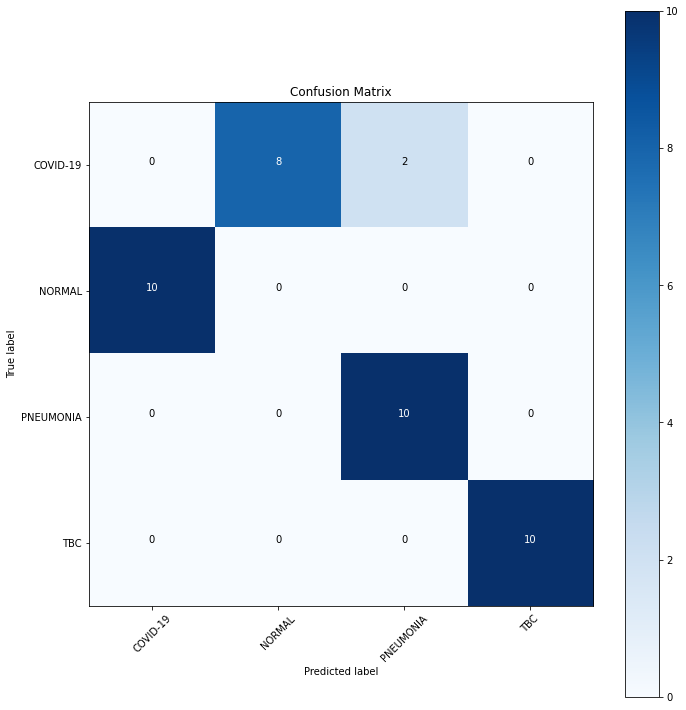

In [21]:
test_datagen = ImageDataGenerator(rescale=1. / 255,
                                  horizontal_flip=True,
                                  fill_mode='nearest')
test_generator = test_datagen.flow_from_directory( './dataset/test',
                                                    target_size = (img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical', shuffle=False)
model = tf.keras.models.load_model('RESNET.h5')
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, labels, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=labels))

In [8]:
from keras.models import load_model
from keras.preprocessing import image
from keras  import preprocessing
model = tf.keras.models.load_model('VGG19epoch10-80%.h5')

result  = model.evaluate_generator(val_set, steps=len(val_set), verbose=1)
print('Loss:', result[0])
print('Accuracy:', result[1])

  ...
    to  
  ['...']
Loss: 1.92128973727813
Accuracy: 0.7636719


In [ ]:
from tensorflow import GradientTape
with tf.GradientTape() as tape:
    last_conv_layer = model.get_layer('block5_conv4')
    iterate=Model([model.inputs],[model.output,last_conv_layer.output])
    model_out,last_conv_layer=iterate(x)
    class_out=model_out[:,np.argmax(model_out[0])]
    grads=tape.gradient(class_out,last_conv_layer)
    pooled_grads=K.mean(grads,axis=(0,1,2))
    heatmap=tf.reduce_mean(tf.multiply(pooled_grads,last_conv_layer),axis=-1)

In [ ]:
image_path="dataset/train/normal/IM-0115-0001.jpeg"
img = cv2.imread(image_path)
INTENSITY=0.5
img1=img.shape[1]
img0=img.shape[0]
heatmap=cv2.resize(heatmap, (img0, img1))
heatmap=cv2.applyColorMap(np.uint8(255*heatmap),cv2.COLORMAP_JET)
img= heatmap * INTENSITY + img

imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
y = model.predict(img_data)
print('Kategori :',labels[np.argmax(y)])
print('Akurasi  :', 100*np.max(y),'%')

# #Test Grad Cam

In [110]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from keras.models import load_model
from keras.preprocessing import image
from keras  import preprocessing


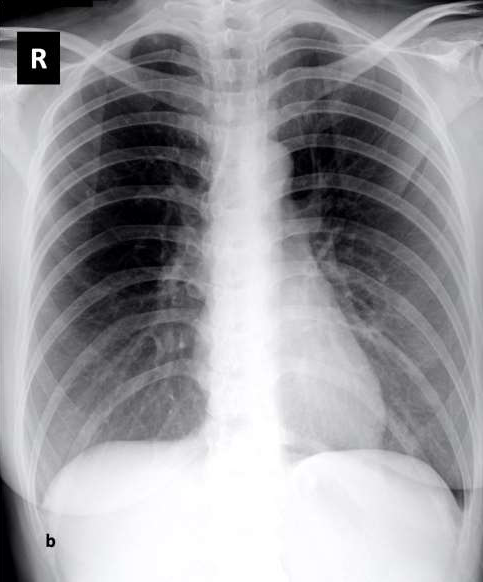

In [125]:
img_size = (256, 256)
preprocess_input = keras.applications.vgg19.preprocess_input


last_conv_layer_name = "block5_pool"
classifier_layer_names = [
          "flatten"
]

# The local path to our target image
img_path = "dataset/test/NORMAL/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-000-fig1b.png"

display(Image(img_path))

In [126]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [127]:
labels = ['COVID-19', 'NORMAL', 'PNEUMONIA', 'TBC']
print(labels)

['COVID-19', 'NORMAL', 'PNEUMONIA', 'TBC']


Kategori : TBC
Akurasi  : 100.0 %


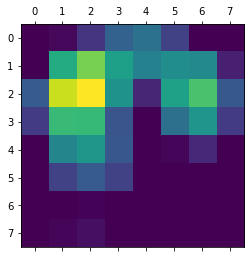

In [128]:
# Prepare image

img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model

model = tf.keras.models.load_model('VGG19-80%-50.h5')

# Print what the top predicted class is

y = model.predict(img_array)
print('Kategori :',labels[np.argmax(y)])
print('Akurasi  :', 100*np.max(y),'%')

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()

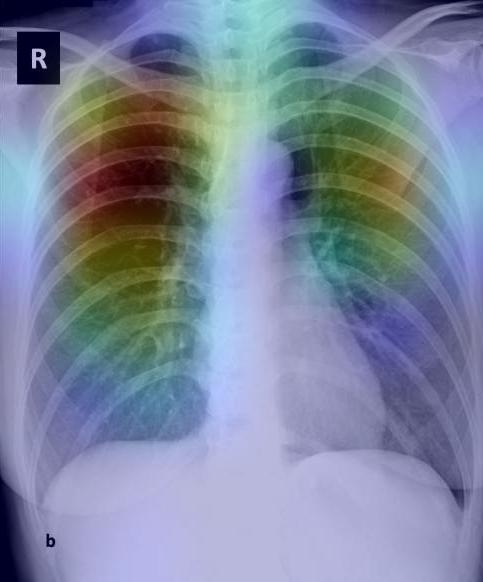

In [129]:
# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))